In [1]:
import anndata as ad
import numpy as np
import scanpy as sc 

from core.preprocessor import Preprocessor
from core.normalizer import Normalizer
from core.differentiator import Differentiator
from core.model_tester import ModelTester
from core.categorizer import Categorizer
from plotmodules.norm_plots import *

CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)


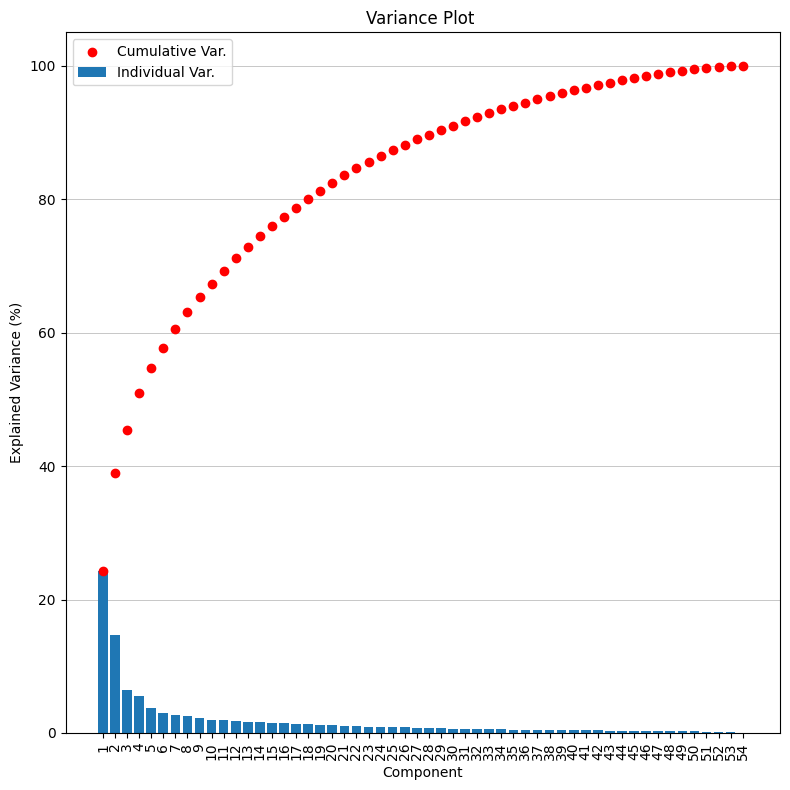

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/preprocessor.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


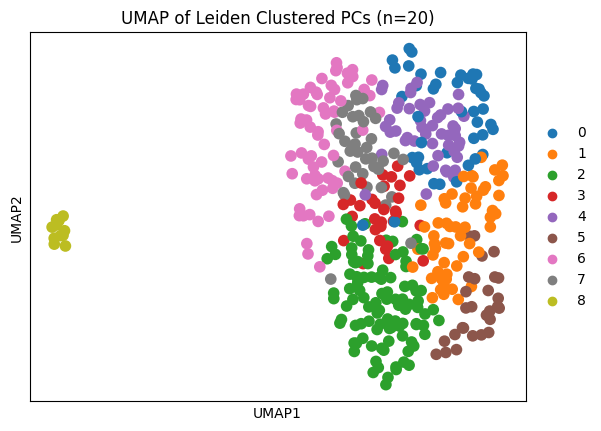

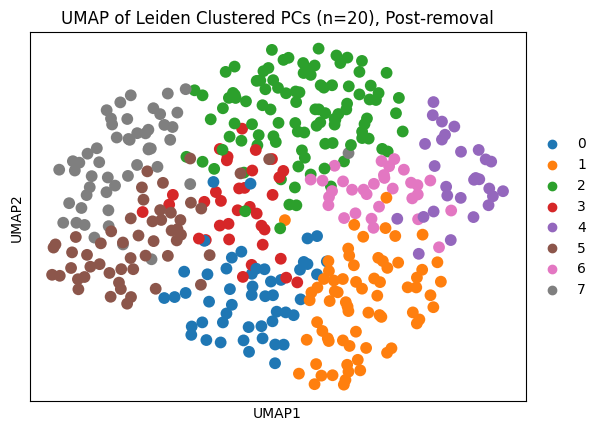

In [2]:
pp = Preprocessor()
pp.show_pca(ct_counts_metadata)
pp.set_n_components(20)
pp.analyze_umap(ct_counts_metadata)
ct_counts_metadata = pp.remove_cluster(ct_counts_metadata, '8')
ct_counts_metadata = ct_counts_metadata[:, ct_counts_metadata.var_names != 'Exc RELN CHD7']

In [3]:
# Regress out post mortem interval
pp.regress_out(ct_counts_metadata, 'pmi')

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.


In [4]:
# Filter out based on cogdx and braaksc
ct_counts_metadata = ct_counts_metadata[(ct_counts_metadata.obs['cogdx'].isin([4, 5]) & ct_counts_metadata.obs['braaksc'].isin([4, 5, 6])) | 
                                        (ct_counts_metadata.obs['cogdx'].isin([1]) & ct_counts_metadata.obs['braaksc'].isin([0, 1, 2, 3]))]

In [5]:
cat = Categorizer(True)
ct_counts_combined = cat.combine_ct(ct_counts_metadata, ['Exc', 'Inh', 'Ast', 'Mic', 'Fib'], 'all')

X_new.shape=(6, 207)


In [6]:
cat.categorize(ct_counts_combined, 'cogdx', cat.COGDX_MAP)

In [7]:
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ranksums

diff = Differentiator('l1', ranksums, fdrcorrection, 'cogdx_cat', ('AD', 'H'))
diff.differentiate(ct_counts_combined)

log2( fold change ) = log2( AD/H )


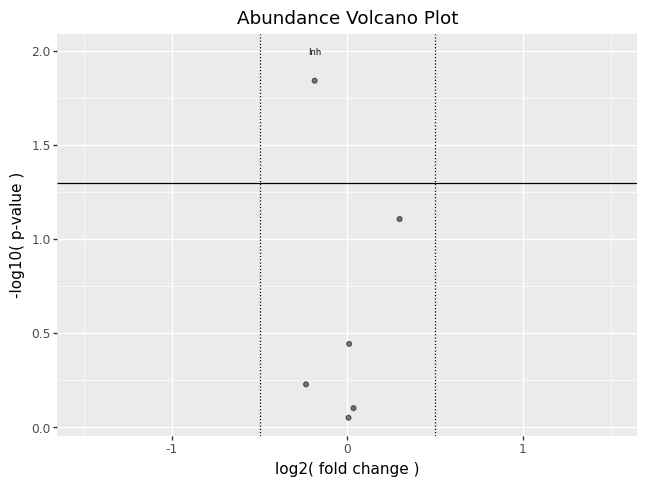

,significant,corr_pvalue,log2fc,log10p
Inh,True,0.014383,-0.186271,1.842143
Mic,False,0.078177,0.297550,1.106923
Other,False,0.360289,0.010180,0.443349
Fib,False,0.590903,-0.235275,0.228484
Ast,False,0.790752,0.035093,0.101960
Exc,False,0.889155,0.006457,0.051023


In [8]:
diff.volcano_plot(ct_counts_combined)
diff.abundance_df.sort_values('corr_pvalue')

log2( fold change ) = log2( Y/N )


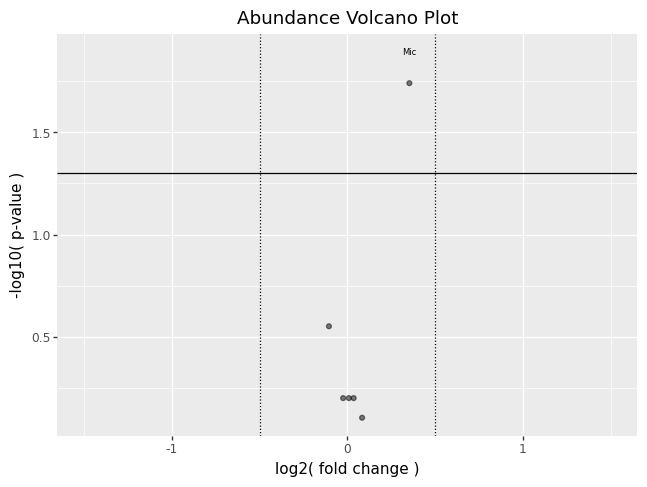

,significant,corr_pvalue,log2fc,log10p
Mic,True,0.018195,0.353085,1.740042
Inh,False,0.280190,-0.104839,0.552547
Exc,False,0.628714,-0.023990,0.201547
Ast,False,0.628714,0.035991,0.201547
Other,False,0.628714,0.008762,0.201547
Fib,False,0.784091,0.084003,0.105633


In [9]:
# CERAD only
cat.categorize(ct_counts_combined, 'ceradsc', cat.CERADSC_MAP, True)

diff_cerad = Differentiator('l1', ranksums, fdrcorrection, 'ceradsc_cat', ('Y', 'N'))
diff_cerad.differentiate(ct_counts_combined)
diff_cerad.volcano_plot(ct_counts_combined)
diff_cerad.abundance_df.sort_values('corr_pvalue')